# Exercises

## Jupyter notebook usage

- To execute a code block (to run a cell) hit: `shift + return` or click on the `Run` button at the top.
- After execution the circle in the top-right corner is filled grey. Once execution has finished the circle will be filled white again.

## Exercises 1 - ohsome API - Aggregation

Question: What is the temporal evolution of the number of hospitals in Florence since 2014?

To answer this question we need to find out the right ohsome API endpoint, how to define the boundary (AOI), the OSM tags to be used as filter and format of the time parameter. Below a list of links is provided to read up on all those topics.

- [ohsome API - Endpoints (elements aggregation)](https://docs.ohsome.org/ohsome-api/v1/endpoints.html#elements-aggregation)
- Boundaries:
    - [ohsome API - Boundaries](https://docs.ohsome.org/ohsome-api/v1/boundaries.html)
    - [OSM Wiki - Bounding Box](https://wiki.openstreetmap.org/wiki/Bounding_Box) 
    - Florence: `11.1645, 43.7034, 11.3242, 43.8579`
- Filter (OSM Tags): 
    - [OSM Wiki - Healthcare](https://wiki.openstreetmap.org/wiki/Healthcare)
    - [ohsome API - Filter](https://docs.ohsome.org/ohsome-api/v1/filter.html)
    - OSM tags describing a hospital:
        - `amenity=hospital`
        - `healthcare=hospital`
- Time:
    - [ohsome API - Time](https://docs.ohsome.org/ohsome-api/stable/time.html)

### Request the API 

Please fill in the empty strings marked with a `TODO` comment.

In [2]:
import json

from datetime import datetime

import requests


base_url = "https://api.ohsome.org/v1"
endpoint = "/elements/count"  # TODO
url = base_url + endpoint
parameters = {  # TODO
    "bboxes": "11.1625,43.7034,11.3242,43.8579",
    "filter": "amenity=hospital or healthcare=hospital",
    "format": "json",
    "time": "2014-01-01/",
}
headers = {
    "accept": "application/json",
    "Content-Type": "application/x-www-form-urlencoded",
}

for value in parameters.values():
    assert value != "", "Please provide values for the parameters"
    
response = requests.post(url, data=parameters, headers=headers)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

print("Response:")
print(json.dumps(response.json(), indent=4))  # Pretty print response

result = response.json()["result"]

Response:
{
    "attribution": {
        "url": "https://ohsome.org/copyrights",
        "text": "\u00a9 OpenStreetMap contributors"
    },
    "apiVersion": "1.9.0",
    "result": [
        {
            "timestamp": "2014-01-01T00:00:00Z",
            "value": 53.0
        },
        {
            "timestamp": "2023-04-23T20:00:00Z",
            "value": 33.0
        }
    ]
}


### Plot the results

Once the numbers of hospitals are requested run below code to plot the results.

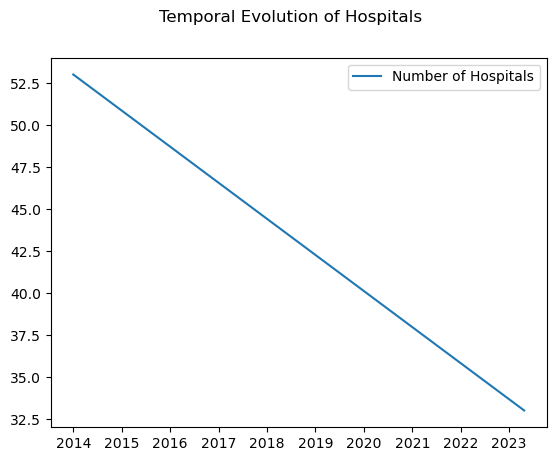

In [3]:
import matplotlib.pyplot as plt


dates = []
values = []
for r in result:
    year = datetime.fromisoformat(r["timestamp"].replace("Z", ""))
    dates.append(year)
    values.append(r["value"])

fig, ax = plt.subplots()
ax.plot(dates, values, label="Number of Hospitals")
ax.legend()
fig.suptitle("Temporal Evolution of Hospitals")
plt.show()

## Exercise 2 - ohsome API - Data extraction

Question: Where were schools mapped over the years?

Goal: Get and visualize the state of schools in OSM on a yearly basis since 2014.

To answer this question we need to get the features representing schools as point from the ohsome API.

- Read up on data extraction here: https://api.ohsome.org/v1/swagger-ui.html?urls.primaryName=Data%20Extraction
- Tags for schools in OSM are described here: https://wiki.openstreetmap.org/wiki/Tag:amenity%3Dschool

### Request the ohsome API

Please fill in the empty strings marked with a `TODO` comment.

In [4]:
import json

import requests


base_url = "https://api.ohsome.org/v1"
endpoint = "/elements/centroid"  # TODO
url = base_url + endpoint

with open("italy-florence.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {  # TODO
    "bpolys": json.dumps(bpolys),
    "filter": "amenity=school",
    "time": "2014-01-01/2023-01-01/P1Y",
}
headers = {
    "accept": "application/json",
    "Content-Type": "application/x-www-form-urlencoded",
}

for value in parameters.values():
    assert value != "", "Please provide values for the parameters"

response = requests.post(url, data=parameters, headers=headers)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

print("Response:")
print(json.dumps(response.json(), indent=4))  # Pretty print response

feature_collection = response.json()

Response:
{
    "attribution": {
        "url": "https://ohsome.org/copyrights",
        "text": "\u00a9 OpenStreetMap contributors"
    },
    "apiVersion": "1.9.0",
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [
                    11.2319799,
                    43.7906592
                ]
            },
            "properties": {
                "@osmId": "relation/1610042",
                "@snapshotTimestamp": "2018-01-01T00:00:00Z"
            }
        },
        {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [
                    11.2319799,
                    43.7906592
                ]
            },
            "properties": {
                "@osmId": "relation/1610042",
                "@snapshotTimestamp": "2019-01-01T00:00:00Z"
            }
        },
    

## Display on a map

In [5]:
import folium

from folium.plugins import TimestampedGeoJson


m = folium.Map()
m.fit_bounds([(43.7034, 11.1645), ( 43.8579, 11.3242,)])

# Add admin boundary to map
with open("italy-florence.geojson", "r") as file:
    admin_boundary = json.load(file)
folium.GeoJson(admin_boundary, name="Admin Boundary").add_to(m)

# Rename property "time"
feature_collection = response.json()
for feature in feature_collection["features"]:
    feature["properties"]["time"] = feature["properties"].pop("@snapshotTimestamp")
    
# Add centroids to map
TimestampedGeoJson(feature_collection, period="P1Y").add_to(m)
m.save("index.html")

# Show map
m

## Exercise 3 - OQT API - Data Quality

OQT provides quality estimations of OpenStreetMap (OSM) data.
OQT calls those estimations Indicators.
Indicators are computed for a specific area and a certain set of aggregated OSM features called Layer. Basically a layer defines the request to the ohsome API.

Two intrinsic quality estimation OQT offers are the Mapping Saturation indicator and the Currentness indicator.

### Request the Mapping Saturation Indicator from the OQT API

The Mapping Saturation indicator calculate the saturation of mapping activity within the last 3 years.
It is based on the premise that each aggregation of features (e.g. length of roads or count of buildings) has a maximum. After increased mapping activity saturation is reached near this maximum.
The Mapping Saturation indicator works well with following layers:

- Building Count (`building_count`)
- Major Roads Length (`major_roads_length`)
- Amenities (`amenities`)
- Point-of-Interests (`poi`)

#### Task

Choose a layer you find interesting and request the Mapping Saturation Indicator from the OQT API.

Properties: 
{'metadata': {'name': 'Mapping Saturation', 'description': 'Calculate if mapping has saturated.\nHigh saturation has been reached if the growth of the fitted curve is minimal.\n'}, 'layer': {'key': 'poi', 'name': 'POI', 'description': 'Points of interest'}, 'result': {'description': 'The saturation of the last 3 years is 68.16%.\nSaturation is in progress (30% < Saturation ≤ 97%).\n', 'timestamp_oqt': '2023-04-26T15:36:50.039264+00:00', 'timestamp_osm': '2023-04-01T00:00:00+00:00', 'value': 0.681579224114671, 'label': 'yellow', 'class': 3}, 'osm_id': -6587564, 'boundary': 'administrative', 'admin_level': 10, 'parents': '-42602,-42472,-41977,-365331', 'name': 'Quartiere 5', 'local_name': 'Quartiere 5', 'name_en': None}

Result: 
{
    "description": "The saturation of the last 3 years is 68.16%.\nSaturation is in progress (30% < Saturation \u2264 97%).\n",
    "timestamp_oqt": "2023-04-26T15:36:50.039264+00:00",
    "timestamp_osm": "2023-04-01T00:00:00+00:00",
    "value":

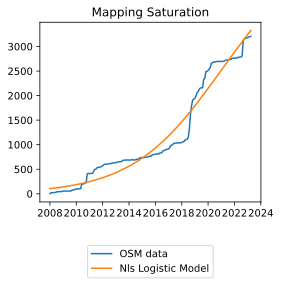

In [6]:
import json

import requests
from IPython.display import SVG, display


base_url = "https://oqt.ohsome.org/api"
endpoint = "/indicator"
url = base_url + endpoint

# OQT size restriction on the input geometry is 100 sqkm
with open("italy-florence-quartier-5.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "name": "MappingSaturation",
    "layerKey": "poi",  # TODO
    "bpolys": bpolys,
    "flatten": False,
    "includeSvg": True,
}

for value in parameters.values():
    assert value != "", "Please provide values for the parameters"

response = requests.post(url, json=parameters)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

properties = response.json()["properties"]
result = properties["result"]
svg = result.pop("svg")

print("Properties: ")
print(properties)
print("")
print("Result: ")
print(json.dumps(result, indent=4))  # Pretty print response

display(SVG(svg))

### Request the Currentness Indicator from the OQT API

The Currentness indicator works well with following layers:

- Building Count (`building_count`)
- Major Roads Count (`major_roads_count`)
- Amenities (`amenities`)

#### Task

Choose a layer you find interesting and request the Currentness Indicator from the OQT API.

Properties: 
{'metadata': {'name': 'Currentness', 'description': 'Ratio of all contributions that have been edited since 2008 until the current day in relation with years without mapping activities in the same\ntime range. \nRefers to data quality in respect to currentness.\n'}, 'layer': {'key': 'amenities', 'name': 'Amenities', 'description': 'All features with the amenities key.'}, 'result': {'description': 'In the last 3 years 39.25 % of the elements were edited the last time.\nIn the period from 4 to 7 years ago 37.21 % of the elements were edited the last time.\nThe remaining 23.54 % were last edited more than 8 years ago.\nThe median currentness of the 1712 features (Amenities) is 3 year(s).\nIt is likely that some features are up-to-date and some features are outdated.\n', 'timestamp_oqt': '2023-04-26T15:36:50.039264+00:00', 'timestamp_osm': '2023-04-23T20:00:00+00:00', 'value': 3, 'label': 'yellow', 'class': 3}, 'osm_id': -6587564, 'boundary': 'administrative', 'admin_level': 1

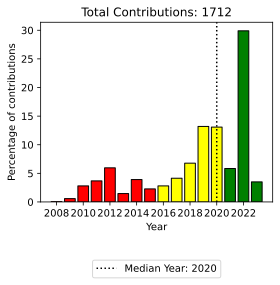

In [7]:
import json

import requests
from IPython.display import SVG, display


base_url = "https://oqt.ohsome.org/api"
endpoint = "/indicator"
url = base_url + endpoint

with open("italy-florence-quartier-5.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "name": "Currentness",
    "layerKey": "amenities",  # TODO
    "bpolys": bpolys,
    "flatten": False,
    "includeSvg": True,
}

for value in parameters.values():
    assert value != "", "Please provide values for the parameters"

response = requests.post(url, json=parameters)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

properties = response.json()["properties"]
result = properties["result"]
svg = result.pop("svg")

print("Properties: ")
print(properties)
print("")
print("Result: ")
print(json.dumps(result, indent=4))  # Pretty print response

display(SVG(svg))